# Example Analysis

This Jupyter/IPython notebook explains how to post-process the tabular tab-separated value format produced by *molyso* to generate various graphs.

If you are unfamiliar with IPython and the NumPy/SciPy/matplotlib/pandas... Stack, we'd suggest you first read a bit about it. We think it's definitely worth giving it a try, as it is a greatly versatile tool for scientific programming endeavours.

This notebook expects a prepared data file in the current working directory.

An example file is shipped with this notebook, it was created by calling molyso:

```bash
python3 -m molyso MM_Cglutamicum_D_aceE.ome.tiff -p -o MM_Cglutamicum_D_aceE_results.tsv
```

The file format is a tab separated table format, which can easily be opened with Pandas.

See the following explanation of the table columns:

 **Column name** | **Contents**
--- | ---
about_to_divide | Whether this cell is about to divide, *i.e.*, this is the last occurrence of this cell
cell_age | The cell age [h], relative to its "birth"
cellxposition | The horizontal position [µm] of the cell (*i.e.*, of the channel)
cellyposition | The vertical position [µm] of the cell within the channel
channel_average_cells | The average count of cells detected in this channel
channel_in_multipoint | The position number of the cell's channel within this multipoint position
channel_orientation | A heuristic result whether high or low y positions represent the open end
channel_width | The width of the cell's channel
division_age | The age [h] at which the cell will divide
elongation_rate | The elongation rate [µm·s⁻¹] of the cell
fluorescence\_*n* | The mean fluorescence of the cell (with background subtracted)
fluorescence\_background\_*n* | The background fluorescence of the cell's image
fluorescence\_count | The count of fluorescences present in the dataset. <br />The other fluorescence\_\*\_*n* fields occurr dependent on this number.
fluorescence\_raw\_*n* | The mean raw fluorescence value of the cell
fluorescence\_std\_*n* | The standard deviation of the fluorescence of the cell
length | The cell length [µm]
multipoint | The multipoint number of the frame of the cell
timepoint | The timepoint [s] of the cell sighting
timepoint_num | The timepoint number (within the dataset) of the cell sighting
uid_cell | A unique id for this tracked cell
uid_parent | A unique id for the cell's parent cell
uid_thiscell | A unique id for this particular cell sighting
uid_track | A unique id for origin (the whole tracking from one start)

In [1]:
file_name = 'MM_Cglutamicum_D_aceE_results.tsv'

In [2]:
# Some general setup routines
%matplotlib inline
%config InlineBackend.figure_formats=['svg']
import pandas
import numpy
from matplotlib import pylab
pandas.options.display.max_columns = None
pylab.rcParams['figure.figsize'] = (10, 6)
pylab.rcParams['svg.fonttype'] = 'none'
pylab.rcParams['font.sans-serif'] = ['Arial']
pylab.rcParams['font.family'] = 'sans-serif'
try:
    import seaborn
except ImportError:
    print("Optional dependency: seaborn to pretty up the graphs.")

In [3]:
# we first open the file via Pandas, it is formatted so that it can be read with the read_table command.

results = pandas.read_table(file_name)

# let's take a sneak peek into the file:
results.head()

,about_to_divide,cell_age,cellxposition,cellyposition,channel_average_cells,channel_in_multipoint,channel_orientation,channel_width,division_age,elongation_rate,fluorescence_0,fluorescence_background_0,fluorescence_count,fluorescence_raw_0,fluorescence_std_0,length,multipoint,timepoint,timepoint_num,uid_cell,uid_parent,uid_thiscell,uid_track
0,0,0.000000,169.5,162.999583,6.920833,0,0,1.235,0.886687,0.000000,7.315575,3246.311622,1,3253.627197,71.395714,1.040,0,1069.611671,1,1,0,2,1
1,0,0.248598,171.5,191.500000,6.920833,0,0,1.235,0.886687,0.023465,17.634413,3245.607042,1,3263.241455,82.589760,2.405,0,1964.563235,2,1,0,3,1
2,0,0.498510,171.5,210.526302,6.920833,0,0,1.235,0.886687,0.015561,18.731400,3246.076706,1,3264.808105,69.626511,3.315,0,2864.248744,3,1,0,4,1
3,0,0.000000,169.5,198.999583,6.920833,0,0,1.235,NaN,0.000000,16.169823,3246.311622,1,3262.481445,79.805779,3.380,0,1069.611671,1,5,0,6,5
4,0,0.000000,169.5,245.999583,6.920833,0,0,1.235,NaN,0.000000,9.266991,3246.311622,1,3255.578613,85.752457,2.470,0,1069.611671,1,7,0,8,7


In [4]:
# Let's take a look at the growth rate.
# Therefore, we take a look at all division events:

division_events = results.query('about_to_divide == 1')

print("We found %d division events (out of %d overall cell sightings)" % (len(division_events), len(results),))

We found 1165 division events (out of 23236 overall cell sightings)


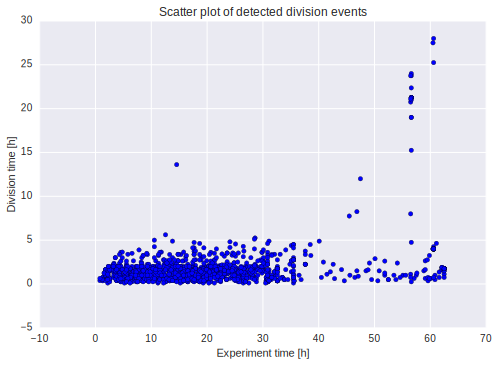

In [5]:
pylab.title('Scatter plot of detected division events')
pylab.ylabel('Division time [h]')
pylab.xlabel('Experiment time [h]')
pylab.scatter(division_events.timepoint / (60.0*60.0), division_events.division_age)

As you can see, the points are quite nicely crowded in a meaningful range, with some outliers.
As a reminder, the dataset was acquired with a 15 min interval, which produces quite some error.

Let's look into a unified growth rate ...

In [6]:
division_events_on_first_day = results.query('about_to_divide == 1 and timepoint < 24*60*60')

doubling_times = numpy.array(division_events_on_first_day.division_age)

print("Unfiltered growth rate on first day µ=%f" % (numpy.log(2)/doubling_times.mean(),))

Unfiltered growth rate on first day µ=0.483987


That way, the data contains quite some outliers, let's remove them by applying some biological prior knowledge:

In [7]:
mu_min = 0.01
mu_max = 1.00

filtered_doubling_times = doubling_times[
    ((numpy.log(2)/mu_min) > doubling_times) & (doubling_times > (numpy.log(2)/mu_max))
]

print("Filtered growth rate on first day µ=%f" % (numpy.log(2)/filtered_doubling_times.mean(),))

Filtered growth rate on first day µ=0.403989


Now, how do we generate an overall growth rate graph from the scattered points?
We use the simple moving average to unify many points into a single points (over time). [And group the points by their timepoints to have a measure if enough division events occured within a certain time frame. There are multiple possible approaches here, and if precise µ is desired, the graph should be based on filtered data as well!]

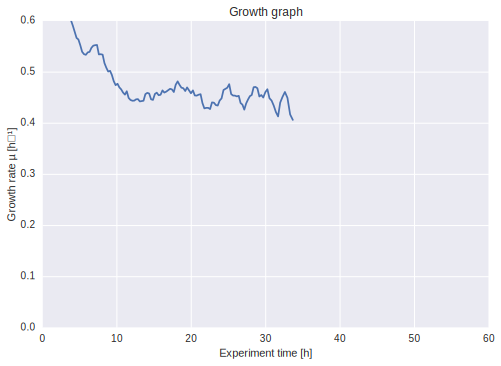

In [8]:
#division_events = division_events.sort('timepoint')
division_events = division_events.query('timepoint < (50.0 * 60.0 * 60.0)')

grouped_division_events = division_events.groupby(by=('timepoint_num',))

window_width = 25

sma_division_age = pandas.rolling_mean(numpy.array(grouped_division_events.mean().division_age), window_width)
sma_time = pandas.rolling_mean(numpy.array(grouped_division_events.mean().timepoint), window_width)
sma_count = pandas.rolling_mean(numpy.array(grouped_division_events.count().division_age), window_width)
sma_division_age[sma_count < 5] = float('nan')

t = sma_time / 60.0 / 60.0
mu = numpy.log(2)/sma_division_age

pylab.title('Growth graph')
pylab.xlabel('Experiment time [h]')
pylab.ylabel('Growth rate µ [h⁻¹]')
pylab.plot(t, mu)
pylab.ylim(0, 0.6)
pylab.xlim(0, 60)
pylab.show()

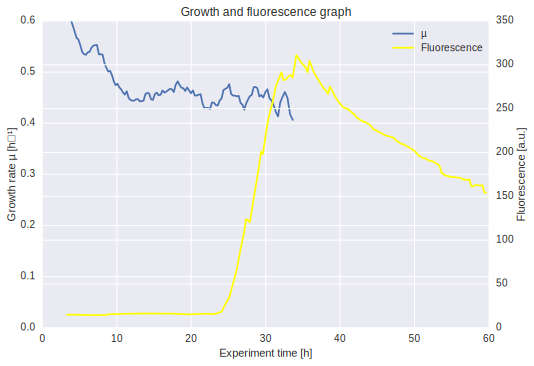

In [9]:
fluor = results.query('fluorescence_0 == fluorescence_0')  # while the example dataset does not contain nans, other data might
fluor = fluor.groupby(by=('timepoint_num'))

fluor_time = pandas.rolling_mean(numpy.array(fluor.timepoint.mean()), window_width)  / (60.0*60.0)
fluor_value = pandas.rolling_mean(numpy.array(fluor.fluorescence_0.mean()), window_width)

pylab.title('Growth and fluorescence graph')
pylab.xlabel('Experiment time [h]')
pylab.ylabel('Growth rate µ [h⁻¹]')
pylab.ylim(0, 0.6)
pylab.plot(t, mu)
pylab.twinx()
pylab.ylabel('Fluorescence [a.u.]')
pylab.plot(0, 0, label='µ')  # to add a legend entry
pylab.plot(fluor_time, fluor_value, label='Fluorescence', color='yellow')
pylab.xlim(0, 60)
pylab.legend()
pylab.show()

Let's look into some single cell data, *e.g.*, cell length or fluorescence (note that different timepoints are used then in the paper):

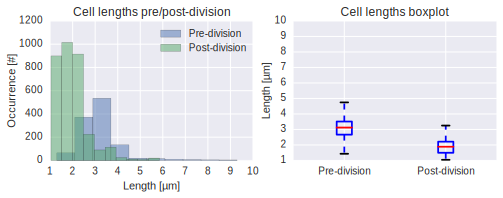

In [10]:
# Dividing cells can be identified by the about_to_divide == 1 flag,
# cells, which resulted from a division have cell_age == 0

pre_division = results.query('about_to_divide==1')
post_division = results.query('cell_age==0')

pylab.subplot(2,2,1)
pylab.title('Cell lengths pre/post-division')
pylab.xlabel('Length [µm]')
pylab.ylabel('Occurrence [#]')
pre_division.length.hist(alpha=0.5, label='Pre-division')
post_division.length.hist(alpha=0.5, label='Post-division')
pylab.legend()
pylab.subplot(2,2,2)
pylab.title('Cell lengths boxplot')
pylab.ylabel('Length [µm]')
pylab.boxplot([pre_division.length, post_division.length], labels=['Pre-division', 'Post-division'])
pylab.show()

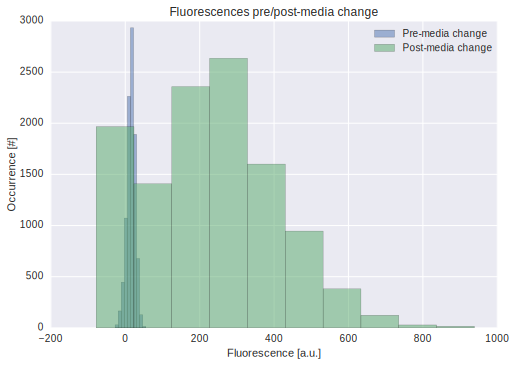

In [11]:
fluor = results.query('fluorescence_0 == fluorescence_0')  # while the example dataset does not contain nans, other data might
pylab.title('Fluorescences pre/post-media change')
pylab.xlabel('Fluorescence [a.u.]')
pylab.ylabel('Occurrence [#]')
fluor.query('timepoint < 24*60*60').fluorescence_0.hist(alpha=0.5, label='Pre-media change')
# 6h gap for the bacteria to start production
fluor.query('timepoint > 30*60*60').fluorescence_0.hist(alpha=0.5, label='Post-media change')
pylab.legend()
pylab.show()

That's it so far. We hope this notebook gave you some ideas how to analyze your data.